In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

In [4]:
!unzip '/content/rating.zip'

Archive:  /content/rating.zip
  inflating: rating.csv              


In [2]:
df = pd.read_csv('rating.csv')

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
print('Number of Users is {}'.format(df.userId.nunique()))
print('Number of Movies is {}'.format(df.movieId.nunique()))
print('Number of ratings is {}'.format(df.shape[0]))

Number of Users is 138493
Number of Movies is 26744
Number of ratings is 20000263


In [5]:
lbl_user  = LabelEncoder()
lbl_movie  = LabelEncoder()
df.userId =  lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

In [6]:
df_train, df_val = train_test_split(df, test_size = 0.2, stratify = df.rating.values)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [8]:
class MovieDataset(Dataset):
  def __init__(self, users, movies, ratings):
    self.users = users
    self.movies = movies
    self.ratings = ratings

  def __len__(self):
    return len(self.users)
  
  def __getitem__(self,item):
    user = self.users[item]
    movie = self.movies[item]
    rating = self.ratings[item]

    return (torch.tensor(user, dtype=torch.long),
             torch.tensor(movie, dtype=torch.long),
             torch.tensor(rating, dtype=torch.float32))

In [9]:
train_dataset = MovieDataset(users = df_train.userId.values, movies = df_train.movieId.values,ratings = df_train.rating.values)
val_dataset = MovieDataset(users = df_val.userId.values,movies = df_val.movieId.values, ratings = df_val.rating.values)

In [21]:
class RecSystemModel(nn.Module):
  def __init__(self, num_users, num_movies, embedding_dim = 64):
    super().__init__()
    self.user_embed = nn.Embedding(num_users, embedding_dim)
    self.movie_embed = nn.Embedding(num_movies, embedding_dim)
    self.fc = nn.Linear(embedding_dim*2, 1)

  def forward(self, users, movies):
    user_embeds = self.user_embed(users)
    movie_embeds = self.movie_embed(movies)
    out = torch.cat([user_embeds,movie_embeds],dim=1)
    output = self.fc(out).view(-1)
    return output


In [22]:
learning_rate = 1e-3
batch_size = 1024
num_epochs = 5
gamma = 0.7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 



train_loader = DataLoader(train_dataset, batch_size = batch_size,shuffle=True,)
valid_loader = DataLoader(val_dataset, batch_size = batch_size,shuffle=True,)


In [23]:
model = RecSystemModel(num_users = len(lbl_user.classes_),num_movies = len(lbl_movie.classes_)).to(device)

In [29]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate )
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [30]:
loss_train = []
loss_val = []
acc_train = []
acc_val = []
for i in range(1,num_epochs+1):
    print('==================== Epoch {} ================'.format(i))
    epoch_loss = 0
    epoch_accuracy = 0

    for user,movie, rating in tqdm(train_loader):
        user = user.to(device)
        movie = movie.to(device)
        label = rating.to(device)

        output = model(user, movie)
        loss = criterion(output, label)

        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for user,movie,rating in tqdm(valid_loader):
          user = user.to(device)
          movie = movie.to(device)
          label = rating.to(device)

          val_output = model(user, movie)
          val_loss = criterion(val_output, label)
          
          epoch_val_loss += val_loss / len(valid_loader)
      

    
    print('Training Loss is {}'.format(epoch_loss))
    print("Validation Loss is {}".format(epoch_val_loss))
    loss_val.append(epoch_val_loss)
    loss_train.append(epoch_loss)

==================== Epoch 1 ================



Training Loss is 0.7421846389770508
Validation Loss is 0.7428302764892578
==================== Epoch 2 ================



Training Loss is 0.7371092438697815
Validation Loss is 0.7407922148704529
==================== Epoch 3 ================



Training Loss is 0.7349424362182617
Validation Loss is 0.740107536315918
==================== Epoch 4 ================



Training Loss is 0.7335940003395081
Validation Loss is 0.7391964793205261
==================== Epoch 5 ================



Training Loss is 0.7325668334960938
Validation Loss is 0.738975465297699


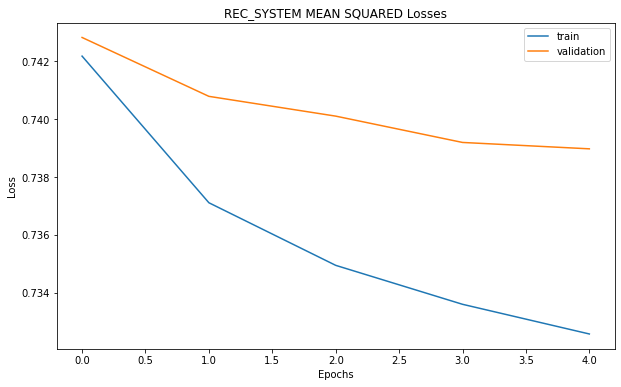

In [31]:
ep = np.arange(num_epochs)
plt.figure(figsize = (10,6))
plt.title('REC_SYSTEM MEAN SQUARED Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(ep,loss_train, label='train')
plt.plot(ep,loss_val , label = 'validation' )
plt.legend(loc = 'best')             